<a href="https://colab.research.google.com/github/Mario-uni/KiPaD/blob/main/KiPaD_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kinetic Parameter Determination

In [1]:
#@title Modules and functions
#@markdown You need to run this cell only once regardless of the number of datasets to be evaluated.
import numpy as np
import pandas as pd
from scipy.linalg import svd

from bokeh.io import output_notebook, show, export_png
from bokeh.plotting import figure, output_file, save, show

from bokeh.palettes import linear_palette, Viridis256
from bokeh.palettes import Category20
from bokeh.models import Button, CustomJS, ColumnDataSource, TabPanel, Tabs, Legend
from bokeh.layouts import column
from bokeh.transform import linear_cmap
output_notebook()

from mpl_toolkits.mplot3d import Axes3D


from google.colab import files
from datetime import datetime
import os

!git clone https://github.com/Mario-uni/KiPaD.git
from KiPaD.funcionesGenerales import  procesa, argLeastSquares, deriv_RK



Cloning into 'KiPaD'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (6/6), done.


In [2]:
#@title Upload files

#@markdown Here you have the option to upload different combinations of files.
#@markdown The most basic one is to just upload the data from one experiment, then there is
#@markdown the option of also uploading the experiment a time zero (including in the filename 'zero)
#@markdown  or over a greater range of time (including in the filename 'extended').
#@markdown Lastly you can upload all three files. The only requirement is to label them accordingly.


# Upload the file and save in a dictionary
uploaded=files.upload()

# Obtain the uploaded file name from the dictionary


file_names = list(uploaded.keys())

def lee_espectro(nombrFichs= file_names, skip_rows= 0):
  df_list = [] # Initialize an empty list to store DataFrames

  for fich in nombrFichs:
    #REead each file into a DataFrame
    temp_df = pd.read_csv(fich, skiprows=[skip_rows], index_col = 0)
    df_list.append(temp_df) # Append each DataFrame to the list

  # Concatenate all DataFrames into one
  df = pd.concat(df_list)

  # Sort the resulting DataFrame by index
  df = df.sort_index()

  # Let's get a name for the plots to follow which data was uploaded
  main = next((fich for fich in nombrFichs if "_t" in fich), None)
  return df, main

datos, file_name= lee_espectro(file_names)
#datos = pd.read_csv(file_name,skiprows=[0])


datos

Saving BoFPR+60NADPH00071_t.csv to BoFPR+60NADPH00071_t.csv


398.820   402.140   405.459   408.777   412.095   415.412   418.728  \
0.001  0.064089  0.064031  0.070361  0.075876  0.084880  0.095658  0.106413   
0.002  0.059408  0.062245  0.065895  0.074150  0.081854  0.092861  0.099944   
0.003  0.062125  0.066152  0.072688  0.071858  0.081988  0.090586  0.103286   
0.004  0.066922  0.066643  0.068816  0.076165  0.081988  0.089453  0.102209   
0.005  0.063661  0.066152  0.069278  0.073002  0.082793  0.088699  0.096627   
...         ...       ...       ...       ...       ...       ...       ...   
0.096  0.044267  0.042602  0.041182  0.042047  0.047339  0.049882  0.052773   
0.097  0.044594  0.044931  0.045253  0.046336  0.047835  0.051549  0.053521   
0.098  0.042961  0.045243  0.043649  0.045932  0.050820  0.048335  0.053200   
0.099  0.039066  0.044620  0.041327  0.045798  0.045918  0.050743  0.053949   
0.100  0.045577  0.044542  0.044815  0.045663  0.047835  0.050513  0.053414   

        422.043   425.357   428.671  ...   968.406   971.595   974.783  \
0.001  0.114355  0.123639  0.131697  ... -0.002868 -0.000559 -0.001293   
0.002  0.111202  0.120858  0.129960  ... -0.004010 -0.000320 -0.002522   
0.003  0.110517  0.117764  0.127368  ... -0.000767 -0.004851 -0.000432   
0.004  0.110118  0.118094  0.124792  ...  0.003467 -0.000719  0.002971   
0.005  0.106883  0.116884  0.122816  ...  0.001537 -0.000080  0.001545   
...         ...       ...       ...  ...       ...       ...       ...   
0.096  0.056838  0.058562  0.059791  ...  0.018017  0.016212  0.016148   
0.097  0.054426  0.057602  0.060714  ...  0.019419  0.019712  0.021689   
0.098  0.056032  0.058466  0.059055  ...  0.017018  0.021389  0.018202   
0.099  0.055630  0.057986  0.057952  ...  0.011862  0.020718  0.019232   
0.100  0.055730  0.056262  0.060529  ...  0.020021  0.018042  0.020847   

        977.970   981.157   984.343   987.529   990.713   993.897   997.080  
0.001 -0.001867 -0.003762  0.000051 -0.001113 -0.002805 -0.002841  0.000295  
0.002 -0.001464 -0.002242 -0.000354 -0.001113 -0.001301 -0.003458  0.002067  
0.003 -0.000253 -0.001480  0.000658 -0.002117 -0.000885 -0.000725  0.001357  
0.004  0.000962  0.001197  0.001775 -0.000318  0.001514  0.002442 -0.001353  
0.005 -0.000051  0.002254  0.001978  0.002127  0.001514  0.000570  0.001121  
...         ...       ...       ...       ...       ...       ...       ...  
0.096  0.020447  0.020616  0.018239  0.018202  0.020484  0.020532  0.018476  
0.097  0.019811  0.021218  0.020249  0.021869  0.020484  0.016745  0.019954  
0.098  0.022678  0.021118  0.020143  0.015775  0.022071  0.019121  0.017861  
0.099  0.020871  0.020315  0.019455  0.020087  0.020539  0.016692  0.019091  
0.100  0.021295  0.023130  0.017923  0.020087  0.019556  0.017176  0.019337  

[100 rows x 185 columns]

In [3]:
#@title Spectra plot
# @markdown Plots Absorbance vs Wavelength and Absorbance vs Time.

df=datos

def create_spectra_plot(df, Title, x_axis, y_axis, Legend, width=1200, height=700):
    # Create a figure
    p = figure(title=Title,
               x_axis_label=x_axis,
               y_axis_label=y_axis,
               width=width, height=height)

    # Define font sizes for the title, axes, and labels
    p.title.text_font_size = '20pt'
    p.xaxis.axis_label_text_font_size = '16pt'
    p.yaxis.axis_label_text_font_size = '16pt'
    p.xaxis.major_label_text_font_size = '12pt'
    p.yaxis.major_label_text_font_size = '12pt'

    # Generate a color palette using Viridis256
    n_lines = len(df.columns)
    colors = linear_palette(Viridis256, n_lines)

    # Create a ColumnDataSource for more efficient rendering

    indices = pd.to_numeric(df.index)
    # Plot each column as a line
    for idx, col in enumerate(df.columns):
        p.line(indices, df[col], legend_label=str(col), line_width=2, color=colors[idx])
        #p.line(pd.to_numeric(df.index), df[col], legend_label=str(col), line_width=2, color=colors[idx])
    # Customize the legend
    p.legend.title = Legend
    p.legend.location = "top_right"
    p.legend.click_policy = "hide"  # Allows hiding lines by clicking their labels
    p.toolbar_location = "below"
    p.legend.visible = False # Initially hide the legend
    p.legend.label_text_font_size = '12pt'
    p.legend.title_text_font_size = '14pt'

    # Create a button to toggle the legend visibility
    button = Button(label="Toggle Legend", button_type= "success")

    # Custom JavaScript to toggle legend visibility
    button.js_on_click(CustomJS(args=dict(legend=p.legend[0]), code= """
    legend.visible = !legend.visible;  // Toggle the visibility
"""))

    # Return the plot object and button as a column layout
    return column(p,button)

df_transposed = df.T # Rows to columns and columns to rows

wavelength_plot_2D = create_spectra_plot(df_transposed, Title = f"Absorbance vs Wavelength // {file_name}",
                                         x_axis="Wavelength (nm)", y_axis ="Absorbance",
                                         Legend = "Time (s)")

time_plot_2D = create_spectra_plot(df, Title= f"Absorbance vs Time // {file_name}",
                                   x_axis = "Time (s)", y_axis = "Absorbance", Legend = "Wavelength (nm)" )

plots = [wavelength_plot_2D,time_plot_2D]


# Create tabs to display both plots
wavelength_panel = TabPanel(child=wavelength_plot_2D, title="Wavelength Plot")
time_panel = TabPanel(child=time_plot_2D, title="Time Plot")

tabs = Tabs(tabs=[wavelength_panel, time_panel])

# Show the plots
show(tabs)







In [4]:
# Convert the dataframe into a Numpy array for the svd to work
datos_array= datos.to_numpy()
datos_array
# Save the columns and row names
Times= datos.index
Wavelengths=datos.columns
print(Times)
print(Wavelengths)


# Performn SVD
U, Sigma, Vt = svd(datos_array, full_matrices= False)


# Display results
print("U Matrix:\n", U)
print("Singular Values:\n", Sigma)
print("V Transpose Matrix:\n", Vt)
U_df = pd.DataFrame(U)
print(U_df)
Sigma_df = pd.DataFrame(Sigma)
print(Sigma_df)
Vt_df = pd.DataFrame(Vt)
print(Vt_df)

Index([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,  0.01,
       0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018, 0.019,  0.02,
       0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027, 0.028, 0.029,  0.03,
       0.031, 0.032, 0.033, 0.034, 0.035, 0.036, 0.037, 0.038, 0.039,  0.04,
       0.041, 0.042, 0.043, 0.044, 0.045, 0.046, 0.047, 0.048, 0.049,  0.05,
       0.051, 0.052, 0.053, 0.054, 0.055, 0.056, 0.057, 0.058, 0.059,  0.06,
       0.061, 0.062, 0.063, 0.064, 0.065, 0.066, 0.067, 0.068, 0.069,  0.07,
       0.071, 0.072, 0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079,  0.08,
       0.081, 0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089,  0.09,
       0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099,   0.1],
      dtype='float64')
Index(['398.820', '402.140', '405.459', '408.777', '412.095', '415.412',
       '418.728', '422.043', '425.357', '428.671',
       ...
       '968.406', '971.595', '974.783', '977.970', '981.157', '984.343'

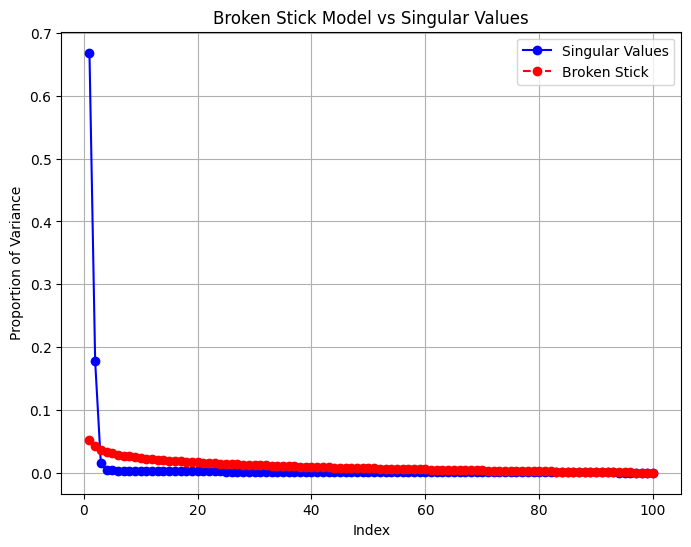

Number of significant singular values (Broken Stick Method): 100
Entropy of singular values: 0.0552
Number of significant singular values (Entropy Method): 2


In [5]:
#@title Determination of the Significant Singular Values (SSV)
# Now we need a method to determine the number of significant singular values

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd
from scipy.stats import entropy


singular_values=Sigma

# Scree Plot Method
def scree_plot(singular_values):
    plt.figure(figsize=(8, 6))
    plt.plot(np.arange(1, len(singular_values)+1), singular_values, 'bo-', markersize=6)
    plt.title("Scree Plot")
    plt.xlabel("Singular Value Index")
    plt.ylabel("Singular Values")
    plt.grid()
    plt.show()

def entropy_selection(singular_values, entropy_threshold):
    total_energy = np.sum(singular_values ** 2)

    # Calculate normalized singular values (f_j)
    f_j = singular_values ** 2 / total_energy

    # Calculate entropy
    entropy_val = -np.sum(f_j * np.log(f_j + np.finfo(float).eps)) / np.log(len(singular_values))

    print(f"Entropy of singular values: {entropy_val:.4f}")

    # Calculate cumulative entropy for each k
    cumulative_entropy = np.zeros(len(singular_values))
    for k in range(len(singular_values)):
        if k == 0:
            cumulative_entropy[k] = 0  # For k=0, entropy is defined as zero
        else:
            cumulative_entropy[k] = -np.sum(f_j[:k+1] * np.log(f_j[:k+1] + np.finfo(float).eps)) / np.log(k + 1)

    # Find the smallest index k such that cumulative entropy meets the threshold
    significant_indices = np.where(cumulative_entropy >= entropy_threshold * entropy_val)[0]

    if len(significant_indices) == 0:
        return 0  # Return 0 if no significant indices found
    else:
        return significant_indices[0] + 1  # Return the number of significant components




# Broken Stick Method
def broken_stick_method(singular_values):
    k = len(singular_values)

    # Calculate the broken stick values
    broken_stick = np.zeros(k)
    for i in range(1, k + 1):
        broken_stick[i - 1] = (1 / k) * np.sum([1 / j for j in range(i, k + 1)])

    # Normalize the singular values and broken stick values for comparison
    singular_values_normalized = singular_values / np.sum(singular_values)
    broken_stick_normalized = broken_stick / np.sum(broken_stick)

    # Plotting the singular values and broken stick model
    plt.figure(figsize=(8, 6))
    plt.plot(np.arange(1, k + 1), singular_values_normalized, 'bo-', label="Singular Values")
    plt.plot(np.arange(1, k + 1), broken_stick_normalized, 'ro--', label="Broken Stick")
    plt.title("Broken Stick Model vs Singular Values")
    plt.xlabel("Index")
    plt.ylabel("Proportion of Variance")
    plt.legend()
    plt.grid()
    plt.show()

    # Determine the number of significant singular values using the broken stick rule
    num_significant = np.where(singular_values_normalized > broken_stick_normalized)[0][-1] + 1
    return num_significant

# Visualize the scree plot
#scree_plot(singular_values)

entropy_threshold= 0.9999 #@param {type: "number"}
if entropy_threshold <0 or entropy_threshold>1:
  entropy_threshold=0.85
  print("Value inputted not valid, entropy_threshold has taken the preset value of 0.85")
# Determine the number of significant singular values using the broken stick method
n_significant_broken_stick = broken_stick_method(singular_values)
print(f"Number of significant singular values (Broken Stick Method): {n_significant_broken_stick}")

# Determine the number of significant singular values using entropy-based selection
n_significant_entropy = entropy_selection(singular_values, entropy_threshold)
print(f"Number of significant singular values (Entropy Method): {n_significant_entropy}")

In [6]:
#@title Dimensionality reduction and Matrix Approximation (Optional)
def matrix_approximation(A, n):
    """
    Approximates matrix A using the top n singular values.

    Parameters:
    - A: The original matrix to approximate.
    - n: Number of significant singular values to use for approximation.

    Returns:
    - A_approx: The approximated matrix.
    """
    # Perform SVD using scipy.linalg.svd
    U, Sigma, VT = svd(A, full_matrices=False)

    # Truncate the matrices to keep only the top 'n' singular values
    U_n = U[:, :n]             # Keep the first 'n' columns of U
    Sigma_n = np.diag(Sigma[:n])  # Keep the first 'n' singular values (diagonal matrix)
    VT_n = VT[:n, :]           # Keep the first 'n' rows of V^T

    # Compute the approximated matrix
    A_approx = np.dot(U_n, np.dot(Sigma_n, VT_n))  # A_approx = U_n * Sigma_n * VT_n

    return A_approx

n_significant_manual = 3 #@param {type:"number"}
#SSV = n_significant_entropy #@param [n_significant_entropy, n_significant_broken, n_significant_manual]

SSV = n_significant_entropy

# Selection of the method for the determination of SSV
Method = "Manual" #@param ["Entropy","Broken-stick", "Manual"]
if Method == "Entropy":
  SSV = n_significant_entropy
elif Method == "Broken-stick":
  SSV = n_significant_broken_stick
else:
  SSV = n_significant_manual


datos_approx = matrix_approximation(datos_array, SSV)
print(datos_approx.shape)
print(datos_array.shape)

(100, 185)
(100, 185)


In [7]:
datos_approx_df= pd.DataFrame(datos_approx, index=Times, columns= Wavelengths)
datos_approx_df

398.820   402.140   405.459   408.777   412.095   415.412   418.728  \
0.001  0.060538  0.064163  0.070135  0.075132  0.085457  0.094560  0.105788   
0.002  0.060565  0.063654  0.068995  0.073836  0.083676  0.092666  0.103558   
0.003  0.063256  0.065143  0.069149  0.073715  0.082601  0.091475  0.101789   
0.004  0.065747  0.066499  0.069241  0.073548  0.081534  0.090301  0.100070   
0.005  0.067193  0.067226  0.069167  0.073284  0.080652  0.089292  0.098656   
...         ...       ...       ...       ...       ...       ...       ...   
0.096  0.042944  0.042747  0.043778  0.045135  0.047479  0.050127  0.053267   
0.097  0.043237  0.043021  0.044040  0.045392  0.047721  0.050362  0.053493   
0.098  0.043051  0.042901  0.043993  0.045357  0.047734  0.050375  0.053531   
0.099  0.042832  0.042634  0.043662  0.045008  0.047334  0.049959  0.053076   
0.100  0.042916  0.042720  0.043752  0.045098  0.047424  0.050045  0.053161   

        422.043   425.357   428.671  ...   968.406   971.595   974.783  \
0.001  0.114879  0.124043  0.131065  ... -0.002591 -0.002332 -0.001230   
0.002  0.112650  0.121606  0.128672  ... -0.002567 -0.002232 -0.001404   
0.003  0.110994  0.119634  0.126890  ... -0.001222 -0.000706 -0.000370   
0.004  0.109385  0.117728  0.125166  ... -0.000007  0.000681  0.000547   
0.005  0.107967  0.116071  0.123566  ...  0.001032  0.001823  0.001423   
...         ...       ...       ...  ...       ...       ...       ...   
0.096  0.055667  0.058427  0.060376  ...  0.018248  0.018524  0.020092   
0.097  0.055883  0.058639  0.060581  ...  0.018502  0.018781  0.020364   
0.098  0.055908  0.058675  0.060601  ...  0.018436  0.018705  0.020317   
0.099  0.055451  0.058191  0.060119  ...  0.018295  0.018570  0.020143   
0.100  0.055528  0.058267  0.060190  ...  0.018387  0.018661  0.020245   

        977.970   981.157   984.343   987.529   990.713   993.897   997.080  
0.001 -0.001135 -0.002119 -0.000118 -0.001771 -0.001923 -0.001861  0.000377  
0.002 -0.001332 -0.002276 -0.000360 -0.001910 -0.001966 -0.001983  0.000053  
0.003 -0.000306 -0.001147  0.000535 -0.000833 -0.000700 -0.000873  0.000676  
0.004  0.000601 -0.000143  0.001320  0.000125  0.000439  0.000116  0.001207  
0.005  0.001480  0.000806  0.002109  0.001024  0.001441  0.001033  0.001817  
...         ...       ...       ...       ...       ...       ...       ...  
0.096  0.020717  0.020831  0.020322  0.019569  0.019303  0.019520  0.018980  
0.097  0.020998  0.021117  0.020592  0.019837  0.019568  0.019787  0.019230  
0.098  0.020951  0.021066  0.020552  0.019788  0.019508  0.019736  0.019205  
0.099  0.020770  0.020886  0.020371  0.019620  0.019352  0.019570  0.019026  
0.100  0.020875  0.020994  0.020474  0.019721  0.019450  0.019670  0.019123  

[100 rows x 185 columns]

In [8]:
#@title Spectra plot
# @markdown Plots Absorbance vs Wavelength and Absorbance vs Time.



df=datos_approx_df


df_transposed = df.T # Rows to columns and columns to rows

wavelength_plot_2D = create_spectra_plot(df_transposed, Title = f"Absorbance vs Wavelength // {file_name}",
                                         x_axis="Wavelength (nm)", y_axis ="Absorbance",
                                         Legend = "Time (s)")

time_plot_2D = create_spectra_plot(df, Title= f"Absorbance vs Time // {file_name}",
                                   x_axis = "Time (s)", y_axis = "Absorbance", Legend = "Wavelength (nm)" )

plots = [wavelength_plot_2D,time_plot_2D]


# Create tabs to display both plots
wavelength_panel = TabPanel(child=wavelength_plot_2D, title="Wavelength Plot")
time_panel = TabPanel(child=time_plot_2D, title="Time Plot")

tabs = Tabs(tabs=[wavelength_panel, time_panel])

# Show the plots
show(tabs)







$Abs_{\lambda,t}= l \cdot(\epsilon (A)_\lambda \cdot [A]_t + \epsilon(B)_\lambda \cdot [B]_t + \epsilon(C)_\lambda \cdot [C]_t + \epsilon(D)_\lambda \cdot [D]_t)$

In [9]:
#@title Reaction Model Parameters { run: "auto" }

# Enter the rate constants for the reactions
#@markdown **Rates:**
k1 = 161.6 #@param {type:"number"}
k1_fixed = False  # @param {type: "boolean"}
#@markdown
k_1 = 0 #@param {type:"number"}
k_1_fixed = False  # @param {type: "boolean"}
#@markdown
k2 = 43.95 #@param {type:"number"}
k2_fixed = False  # @param {type: "boolean"}
#@markdown
k_2 = 0 #@param {type:"number"}
k_2_fixed = False  # @param {type: "boolean"}
#@markdown
k3 = 0 #@param {type:"number"}
k3_fixed = False  # @param {type: "boolean"}
#@markdown
k_3 = 0 #@param {type:"number"}
k_3_fixed = False  # @param {type: "boolean"}

# Initial concentrations of species
#@markdown **Initial Concentrations:**
A0 = 20.0 #@param {type:"number"}
A0_fixed = True  # @param {type: "boolean"}

B0 = 0.0 #@param {type:"number"}
B0_fixed = True  # @param {type: "boolean"}

C0 = 0.0 #@param {type:"number"}
C0_fixed = True  # @param {type: "boolean"}

D0 = 0.0 #@param {type:"number"}
D0_fixed = True  # @param {type: "boolean"}




# Initialize list for the fixed and variable parameters (these last ones are to be optimized later)
fixed_ks = {}
variable_ks = {}


if k1_fixed == True:
    fixed_ks['k1'] = k1
else:
    variable_ks['k1'] = k1

if k_1_fixed == True:
    fixed_ks['k_1'] = k_1
else:
    variable_ks['k_1'] = k_1

if k2_fixed == True:
    fixed_ks['k2'] = k2
else:
    variable_ks['k2'] = k2

if k_2_fixed == True:
    fixed_ks['k_2'] = k_2
else:
    variable_ks['k_2'] = k_2

if k3_fixed == True:
    fixed_ks['k3'] = k3
else:
    variable_ks['k3'] = k3

if k_3_fixed == True:
    fixed_ks['k_3'] = k_3
else:
    variable_ks['k_3'] = k_3


fixed_conc ={}
variable_conc ={}


if A0_fixed == True:
    fixed_conc['A0'] = A0
else:
    variable_conc['A0'] = A0
if B0_fixed == True:
    fixed_conc['B0'] = B0
else:
    variable_conc['B0'] = B0

if C0_fixed == True:
    fixed_conc['C0'] = C0
else:
    variable_conc['C0'] = C0

if D0_fixed == True:
    fixed_conc['D0'] = D0
else:
    variable_conc['D0'] = D0



# Output of the fixed and variable rate constants
print("Fixed Rate Constants:")
for key, value in fixed_ks.items():
    print(f"{key} = {value}")

print("\nVariable Rate Constants:")
for key, value in variable_ks.items():
    print(f"{key} = {value}")

print("\nFixed Concentrations:")
for key, value in fixed_conc.items():
    print(f"{key} = {value}")

print("\nVariable Concentrations:")
for key, value in variable_conc.items():
    print(f"{key} = {value}")


# Group both rate constant dictionaries into one
initial_ks = {**fixed_ks, **variable_ks}
initial_conc = {**fixed_conc, **variable_conc}

# Reaction model function (A ⇔ B ⇔ C ⇔ D)
def reaction_model(y, t, rate_constants, n_species):
    # Extract rate constant from initial_ks
    k1 = initial_ks['k1']
    k_1 = initial_ks['k_1']
    k2 = initial_ks['k2']
    k_2 = initial_ks['k_2']
    k3 = initial_ks['k3']
    k_3 = initial_ks['k_3']

    if n_species == 2:
      A, B = y # Un pack the current values of each species
      dY_dt = np.zeros(len(y))
      dA_dt = -k1 * A + k_1 * B
      dB_dt = k1 * A - k_1 * B
      dY_dt[0] = dA_dt
      dY_dt[1] = dB_dt

    elif n_species == 3:
      A, B, C = y # Un pack the current values of each species
      dY_dt = np.zeros(len(y))
      dA_dt = -k1 * A + k_1 * B
      dB_dt = k1 * A - k_1 * B - k2 * B + k_2 * C
      dC_dt = k2 * B - k_2 * C
      dY_dt[0] = dA_dt
      dY_dt[1] = dB_dt
      dY_dt[2] = dC_dt
    elif n_species == 4:
      A, B, C, D = y
      dY_dt = np.zeros(len(y))
      dA_dt = -k1 * A + k_1 * B
      dB_dt = k1 * A - k_1 * B - k2 * B + k_2 * C
      dC_dt = k2 * B - k_2 * C - k3 * C + k_3 * D
      dD_dt = k3 * C - k_3 * D
      dY_dt[0] = dA_dt
      dY_dt[1] = dB_dt
      dY_dt[2] = dC_dt
      dY_dt[3] = dC_dt
    return dY_dt  # Return as NumPy array


y0= [*initial_conc.values()] # with the "*" operator we unpack the values of the dictionary

print(y0)

def solve_conc_profile (f, y0, t, rate_constants, n_species):
  n_steps=len(t)
  #n_species = len(y0)
  delta_t = t[1]-t[0]

  # Initialize the solution array to store each species' concentration at each time step
  solution = np.zeros((n_steps, n_species))
  #print(solution[0])
  solution[0]= y0[0:n_species] # Initial conditions

  # Iterate through each time step using the function deriv_RK from funcionesGenerales
  for i in range(1, n_steps):
    current_t = t[i-1]
    current_y = solution[i-1]

    # Use deriv_RK to calculate the next step
    solution[i] = current_y + delta_t * deriv_RK(f, current_y, current_t, delta_t, rate_constants=rate_constants, n_species=n_species)

  # df = pd.DataFrame(solution, index=t, columns= ["A", "B", "C", "D"]) # shape (time, species)
  # Generate column names based on the number of species
  column_names = [f"{chr(65 + j)}" for j in range(n_species)]  # 'A', 'B', 'C', ...

  # Create the DataFrame without empty columns
  df = pd.DataFrame(solution, index=t, columns=column_names)  # shape (time, species)
  return df

concentration_matrix_rk4 = solve_conc_profile(reaction_model, y0, t=df.index, rate_constants=initial_ks, n_species=3)

# Output the concentration matrix
concentration_matrix_rk4  # This should match the structure of `odeint` output


Fixed Rate Constants:

Variable Rate Constants:
k1 = 161.6
k_1 = 0
k2 = 43.95
k_2 = 0
k3 = 0
k_3 = 0

Fixed Concentrations:
A0 = 20.0
B0 = 0.0
C0 = 0.0
D0 = 0.0

Variable Concentrations:
[20.0, 0.0, 0.0, 0.0]


A         B          C
0.001  20.000000  0.000000   0.000000
0.002  17.015647  2.917988   0.066365
0.003  14.476612  5.275093   0.248295
0.004  12.316446  7.160402   0.523152
0.005  10.478615  8.649480   0.871905
...          ...       ...        ...
0.096   0.000004  0.422265  19.577730
0.097   0.000004  0.404109  19.595887
0.098   0.000003  0.386734  19.613263
0.099   0.000003  0.370105  19.629892
0.100   0.000002  0.354192  19.645806

[100 rows x 3 columns]

In [10]:
datos_approx_df

398.820   402.140   405.459   408.777   412.095   415.412   418.728  \
0.001  0.060538  0.064163  0.070135  0.075132  0.085457  0.094560  0.105788   
0.002  0.060565  0.063654  0.068995  0.073836  0.083676  0.092666  0.103558   
0.003  0.063256  0.065143  0.069149  0.073715  0.082601  0.091475  0.101789   
0.004  0.065747  0.066499  0.069241  0.073548  0.081534  0.090301  0.100070   
0.005  0.067193  0.067226  0.069167  0.073284  0.080652  0.089292  0.098656   
...         ...       ...       ...       ...       ...       ...       ...   
0.096  0.042944  0.042747  0.043778  0.045135  0.047479  0.050127  0.053267   
0.097  0.043237  0.043021  0.044040  0.045392  0.047721  0.050362  0.053493   
0.098  0.043051  0.042901  0.043993  0.045357  0.047734  0.050375  0.053531   
0.099  0.042832  0.042634  0.043662  0.045008  0.047334  0.049959  0.053076   
0.100  0.042916  0.042720  0.043752  0.045098  0.047424  0.050045  0.053161   

        422.043   425.357   428.671  ...   968.406   971.595   974.783  \
0.001  0.114879  0.124043  0.131065  ... -0.002591 -0.002332 -0.001230   
0.002  0.112650  0.121606  0.128672  ... -0.002567 -0.002232 -0.001404   
0.003  0.110994  0.119634  0.126890  ... -0.001222 -0.000706 -0.000370   
0.004  0.109385  0.117728  0.125166  ... -0.000007  0.000681  0.000547   
0.005  0.107967  0.116071  0.123566  ...  0.001032  0.001823  0.001423   
...         ...       ...       ...  ...       ...       ...       ...   
0.096  0.055667  0.058427  0.060376  ...  0.018248  0.018524  0.020092   
0.097  0.055883  0.058639  0.060581  ...  0.018502  0.018781  0.020364   
0.098  0.055908  0.058675  0.060601  ...  0.018436  0.018705  0.020317   
0.099  0.055451  0.058191  0.060119  ...  0.018295  0.018570  0.020143   
0.100  0.055528  0.058267  0.060190  ...  0.018387  0.018661  0.020245   

        977.970   981.157   984.343   987.529   990.713   993.897   997.080  
0.001 -0.001135 -0.002119 -0.000118 -0.001771 -0.001923 -0.001861  0.000377  
0.002 -0.001332 -0.002276 -0.000360 -0.001910 -0.001966 -0.001983  0.000053  
0.003 -0.000306 -0.001147  0.000535 -0.000833 -0.000700 -0.000873  0.000676  
0.004  0.000601 -0.000143  0.001320  0.000125  0.000439  0.000116  0.001207  
0.005  0.001480  0.000806  0.002109  0.001024  0.001441  0.001033  0.001817  
...         ...       ...       ...       ...       ...       ...       ...  
0.096  0.020717  0.020831  0.020322  0.019569  0.019303  0.019520  0.018980  
0.097  0.020998  0.021117  0.020592  0.019837  0.019568  0.019787  0.019230  
0.098  0.020951  0.021066  0.020552  0.019788  0.019508  0.019736  0.019205  
0.099  0.020770  0.020886  0.020371  0.019620  0.019352  0.019570  0.019026  
0.100  0.020875  0.020994  0.020474  0.019721  0.019450  0.019670  0.019123  

[100 rows x 185 columns]

In [11]:
#@title Species' spectra
def species_spectra (abs, n_species, C_profile, pathlength):
  spectra = {}
  if n_species == 2:
    spectra['A'] = abs.iloc[0,:]/(C_profile.iloc[0,0] * pathlength)
    spectra['B'] = abs.iloc[-1,:]/(C_profile.iloc[-1,1] * pathlength)
  elif n_species == 3:
    spectra['A'] = abs.iloc[0,:]/(C_profile.iloc[0,0] * pathlength )
    spectra['B'] = None
    spectra['C'] = abs.iloc[-1,:]/(C_profile.iloc[-1,2] * pathlength )


    max_conc_B = C_profile.iloc[:,1].abs().max() # absolute maximum
    #print(max_conc_B)
    tB_label = C_profile.iloc[:,1].abs().idxmax() # This get the time not the positional idx
    tB = C_profile.index.get_loc(tB_label)
    #print(tB)
    spectra['B'] = (1/(max_conc_B ))*(abs.iloc[tB,:]/(pathlength) - spectra['A']*C_profile.iloc[tB,0]  - spectra['C']*C_profile.iloc[tB,-1] )
  elif n_species == 4:
    spectra['A'] = abs.iloc[0,:]/(C_profile.iloc[0,0] * pathlength)
    spectra['B'] = None
    spectra['C'] = None
    spectra['D'] = abs.iloc[-1,:]/(C_profile.iloc[-1,3] * pathlength)

    max_conc_B = C_profile.iloc[:,1].abs().max() # absolute maximum
    #print(max_conc_B)
    tB_label = C_profile.iloc[:,1].abs().idxmax() # This get the time not the positional idx
    tB = C_profile.index.get_loc(tB_label)
    #print(tB)

    max_conc_C = C_profile.iloc[:,2].abs().max() # absolute maximum

    tC_label = C_profile.iloc[:,2].abs().idxmax() # This get the time not the positional idx
    tC = C_profile.index.get_loc(tC_label)

    factor = C_profile.iloc[tC,2]/(C_profile.iloc[tC,2]*C_profile.iloc[tB,1] - C_profile.iloc[tB,2]*C_profile.iloc[tC,1])
    mu = C_profile.iloc[tB,2]/C_profile.iloc[tC,2]

    spectra['B']= factor *(abs.iloc[tB,:]/(pathlength) -
                           spectra['A']*C_profile.iloc[tB,0] -
                           spectra['D']*C_profile.iloc[tB,-1] -
                           mu*(abs.iloc[tC,:]/(pathlength) -
                               spectra['A']*C_profile.iloc[tC,0] -
                               spectra['D']*C_profile.iloc[tC,-1]))
    spectra['C'] =(1/C_profile.iloc[tC,2])* (abs.iloc[tC,:]/(pathlength) -
                                        spectra['A']*C_profile.iloc[tC,0] -
                                        spectra['B']*C_profile.iloc[tC,1] -
                                        spectra['D']*C_profile.iloc[tC,-1] )
  sol = pd.DataFrame.from_dict(spectra)
  sol= sol.T
  return sol

solutions = species_spectra(abs=datos_approx_df,n_species=3,C_profile=concentration_matrix_rk4, pathlength=1)

In [12]:
solutions

398.820   402.140   405.459   408.777   412.095   415.412   418.728  \
A  0.003027  0.003208  0.003507  0.003757  0.004273  0.004728  0.005289   
B  0.003600  0.003437  0.003345  0.003522  0.003776  0.004215  0.004624   
C  0.002184  0.002175  0.002227  0.002296  0.002414  0.002547  0.002706   

    422.043   425.357   428.671  ...   968.406   971.595   974.783   977.970  \
A  0.005744  0.006202  0.006553  ... -0.000130 -0.000117 -0.000062 -0.000057   
B  0.005137  0.005516  0.005943  ... -0.000014  0.000053 -0.000062 -0.000068   
C  0.002826  0.002966  0.003064  ...  0.000936  0.000950  0.001031  0.001063   

    981.157   984.343   987.529   990.713   993.897   997.080  
A -0.000106 -0.000006 -0.000089 -0.000096 -0.000093  0.000019  
B -0.000094 -0.000045 -0.000071 -0.000017 -0.000065 -0.000081  
C  0.001069  0.001042  0.001004  0.000990  0.001001  0.000973  

[3 rows x 185 columns]

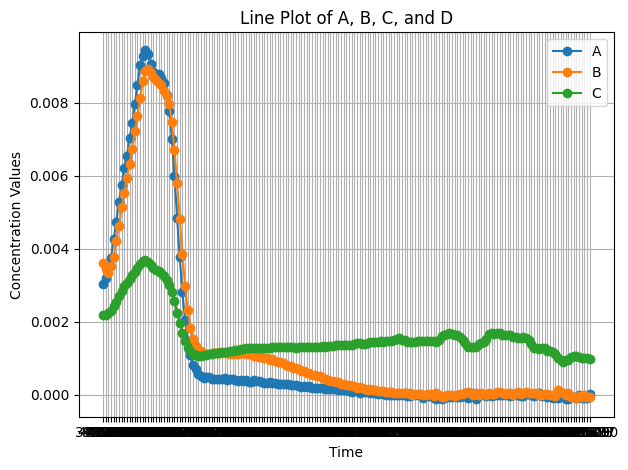

In [13]:
solutions

for row in solutions.index:
    plt.plot(solutions.columns, solutions.loc[row], marker='o', label=row)

# Add titles and labels
plt.title('Line Plot of A, B, C, and D')
plt.xlabel('Time')
plt.ylabel('Concentration Values')
plt.legend()  # Show legend
plt.grid(True)  # Add grid for better readability
plt.tight_layout()  # Adjust layout

# Show the plot
plt.show()

In [14]:
op=np.dot(concentration_matrix_rk4,solutions)
op=pd.DataFrame(op)
op

0         1         2         3         4         5         6    \
0   0.060538  0.064163  0.070135  0.075132  0.085457  0.094560  0.105788   
1   0.062155  0.064761  0.069579  0.074352  0.083884  0.092919  0.103675   
2   0.063354  0.065111  0.068966  0.073534  0.082374  0.091314  0.101636   
3   0.064204  0.065258  0.068310  0.072691  0.080926  0.089747  0.099672   
4   0.064765  0.065238  0.067623  0.071833  0.079538  0.088223  0.097780   
..       ...       ...       ...       ...       ...       ...       ...   
95  0.044287  0.044023  0.045013  0.046429  0.048854  0.051652  0.054929   
96  0.044262  0.044000  0.044993  0.046407  0.048829  0.051621  0.054894   
97  0.044237  0.043978  0.044974  0.046386  0.048805  0.051592  0.054861   
98  0.044213  0.043957  0.044955  0.046365  0.048783  0.051565  0.054829   
99  0.044191  0.043937  0.044937  0.046346  0.048761  0.051538  0.054798   

         7         8         9    ...       175       176       177       178  \
0   0.114879  0.124043  0.131065  ... -0.002591 -0.002332 -0.001230 -0.001135   
1   0.112915  0.121828  0.129054  ... -0.002183 -0.001767 -0.001158 -0.001094   
2   0.110955  0.119622  0.126981  ... -0.001716 -0.001174 -0.000959 -0.000918   
3   0.109009  0.117440  0.124872  ... -0.001205 -0.000561 -0.000659 -0.000632   
4   0.107088  0.115290  0.122746  ... -0.000662  0.000063 -0.000278 -0.000259   
..       ...       ...       ...  ...       ...       ...       ...       ...   
95  0.057505  0.060395  0.062491  ...  0.018318  0.018619  0.020149  0.020774   
96  0.057463  0.060349  0.062439  ...  0.018335  0.018635  0.020169  0.020795   
97  0.057423  0.060304  0.062389  ...  0.018352  0.018651  0.020188  0.020814   
98  0.057385  0.060262  0.062341  ...  0.018367  0.018666  0.020206  0.020833   
99  0.057348  0.060221  0.062295  ...  0.018382  0.018680  0.020224  0.020851   

         179       180       181       182       183       184  
0  -0.002119 -0.000118 -0.001771 -0.001923 -0.001861  0.000377  
1  -0.002007 -0.000163 -0.001647 -0.001619 -0.001706  0.000149  
2  -0.001765 -0.000065 -0.001406 -0.001234 -0.001441  0.000088  
3  -0.001419  0.000149 -0.001073 -0.000785 -0.001087  0.000162  
4  -0.000992  0.000456 -0.000665 -0.000288 -0.000664  0.000346  
..       ...       ...       ...       ...       ...       ...  
95  0.020881  0.020384  0.019622  0.019375  0.019575  0.019023  
96  0.020902  0.020403  0.019642  0.019394  0.019594  0.019042  
97  0.020923  0.020422  0.019661  0.019411  0.019613  0.019060  
98  0.020942  0.020440  0.019678  0.019428  0.019630  0.019078  
99  0.020960  0.020458  0.019696  0.019444  0.019647  0.019094  

[100 rows x 185 columns]

In [15]:
#@title Cost function
def cost_function(abs, rate_consts, conc, n_species, pathlength=1):
  y0= [*conc.values()] # with the "*" operator we unpack the values of the dictionary

  #Solve for concentrations
  C_matrix=solve_conc_profile(reaction_model, y0, t=abs.index, rate_constants= rate_consts, n_species=n_species)


  #Construct full extinction coefficient matrix
  S_matrix= species_spectra(abs= abs, n_species=n_species, C_profile=C_matrix, pathlength=pathlength)

  #Use Lambert-Beer Law to calculate predicted absorbance (n_Lambda x n_t)
  D_model = pathlength * np.dot(C_matrix, S_matrix)
  D_exp = abs
  #Compute residuals (difference between experimental abd predicted absorbance)
  residuals= D_exp - D_model
  D_model_df =pd.DataFrame(D_model, index=D_exp.index, columns= D_exp.columns)

  #return D_model_df
  return D_model_df
sols= cost_function(datos_approx_df, initial_ks, initial_conc, n_species=3)
sols

398.820   402.140   405.459   408.777   412.095   415.412   418.728  \
0.001  0.060538  0.064163  0.070135  0.075132  0.085457  0.094560  0.105788   
0.002  0.062155  0.064761  0.069579  0.074352  0.083884  0.092919  0.103675   
0.003  0.063354  0.065111  0.068966  0.073534  0.082374  0.091314  0.101636   
0.004  0.064204  0.065258  0.068310  0.072691  0.080926  0.089747  0.099672   
0.005  0.064765  0.065238  0.067623  0.071833  0.079538  0.088223  0.097780   
...         ...       ...       ...       ...       ...       ...       ...   
0.096  0.044287  0.044023  0.045013  0.046429  0.048854  0.051652  0.054929   
0.097  0.044262  0.044000  0.044993  0.046407  0.048829  0.051621  0.054894   
0.098  0.044237  0.043978  0.044974  0.046386  0.048805  0.051592  0.054861   
0.099  0.044213  0.043957  0.044955  0.046365  0.048783  0.051565  0.054829   
0.100  0.044191  0.043937  0.044937  0.046346  0.048761  0.051538  0.054798   

        422.043   425.357   428.671  ...   968.406   971.595   974.783  \
0.001  0.114879  0.124043  0.131065  ... -0.002591 -0.002332 -0.001230   
0.002  0.112915  0.121828  0.129054  ... -0.002183 -0.001767 -0.001158   
0.003  0.110955  0.119622  0.126981  ... -0.001716 -0.001174 -0.000959   
0.004  0.109009  0.117440  0.124872  ... -0.001205 -0.000561 -0.000659   
0.005  0.107088  0.115290  0.122746  ... -0.000662  0.000063 -0.000278   
...         ...       ...       ...  ...       ...       ...       ...   
0.096  0.057505  0.060395  0.062491  ...  0.018318  0.018619  0.020149   
0.097  0.057463  0.060349  0.062439  ...  0.018335  0.018635  0.020169   
0.098  0.057423  0.060304  0.062389  ...  0.018352  0.018651  0.020188   
0.099  0.057385  0.060262  0.062341  ...  0.018367  0.018666  0.020206   
0.100  0.057348  0.060221  0.062295  ...  0.018382  0.018680  0.020224   

        977.970   981.157   984.343   987.529   990.713   993.897   997.080  
0.001 -0.001135 -0.002119 -0.000118 -0.001771 -0.001923 -0.001861  0.000377  
0.002 -0.001094 -0.002007 -0.000163 -0.001647 -0.001619 -0.001706  0.000149  
0.003 -0.000918 -0.001765 -0.000065 -0.001406 -0.001234 -0.001441  0.000088  
0.004 -0.000632 -0.001419  0.000149 -0.001073 -0.000785 -0.001087  0.000162  
0.005 -0.000259 -0.000992  0.000456 -0.000665 -0.000288 -0.000664  0.000346  
...         ...       ...       ...       ...       ...       ...       ...  
0.096  0.020774  0.020881  0.020384  0.019622  0.019375  0.019575  0.019023  
0.097  0.020795  0.020902  0.020403  0.019642  0.019394  0.019594  0.019042  
0.098  0.020814  0.020923  0.020422  0.019661  0.019411  0.019613  0.019060  
0.099  0.020833  0.020942  0.020440  0.019678  0.019428  0.019630  0.019078  
0.100  0.020851  0.020960  0.020458  0.019696  0.019444  0.019647  0.019094  

[100 rows x 185 columns]

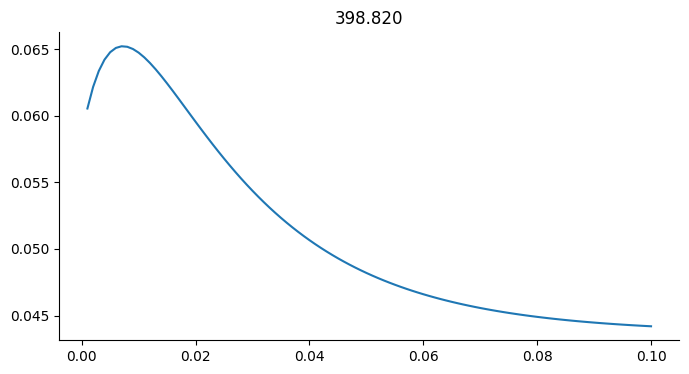

In [16]:
from matplotlib import pyplot as plt
sols['398.820'].plot(kind='line', figsize=(8, 4), title='398.820')
plt.gca().spines[['top', 'right']].set_visible(False)

In [17]:
#@title Spectra plot (Model)
# @markdown Plots Absorbance vs Wavelength and Absorbance vs Time.



df_e=sols


df_e_transposed = df_e.T # Rows to columns and columns to rows

wavelength_plot_2D = create_spectra_plot(df_e_transposed, Title = f"Absorbance vs Wavelength // {file_name}",
                                         x_axis="Wavelength (nm)", y_axis ="Absorbance",
                                         Legend = "Time (s)")

time_plot_2D = create_spectra_plot(df_e, Title= f"Absorbance vs Time // {file_name}",
                                   x_axis = "Time (s)", y_axis = "Absorbance", Legend = "Wavelength (nm)" )

plots = [wavelength_plot_2D,time_plot_2D]


# Create tabs to display both plots
wavelength_panel = TabPanel(child=wavelength_plot_2D, title="Wavelength Plot")
time_panel = TabPanel(child=time_plot_2D, title="Time Plot")

tabs = Tabs(tabs=[wavelength_panel, time_panel])

# Show the plots
show(tabs)

In [18]:
'''from scipy.optimize import curve_fit, leastsq



initial_params_var= {**variable_ks, **variable_conc}
# Extraer los parámetros optimizados
param_names = list(initial_params_var.keys())
initial_params_list=list(initial_params_var.values())


# Realizar la optimización utilizando el método de mínimos cuadrados
optimized_params,_=leastsq(cost_function, initial_params_list, args=(datos_approx_df, initial_ks, initial_conc, 3))


# Creamos un diccionario con los parametros optimizados
optimized_params=dict(zip(param_names, optimized_params))'''

'from scipy.optimize import curve_fit, leastsq\n\n\n\ninitial_params_var= {**variable_ks, **variable_conc}\n# Extraer los parámetros optimizados\nparam_names = list(initial_params_var.keys())\ninitial_params_list=list(initial_params_var.values())\n\n\n# Realizar la optimización utilizando el método de mínimos cuadrados\noptimized_params,_=leastsq(cost_function, initial_params_list, args=(datos_approx_df, initial_ks, initial_conc, 3))\n\n\n# Creamos un diccionario con los parametros optimizados\noptimized_params=dict(zip(param_names, optimized_params))'

In [20]:
'''initial_params_var'''

SyntaxError: incomplete input (<ipython-input-20-8084709aedd0>, line 1)

In [23]:
'''#@title Procesa

initial_params= {**initial_ks, **initial_conc}
initial_params_var= {**variable_ks, **variable_conc}
# Prepare the list of the parameters names to be opimized
nombrParVar = list(initial_params_var.keys())

# Independent values (time and wavelength) and dependent values (Absorbance)
fKwargs = dict(times = datos_approx_df.index) # Data of ligand solution volume added
 # Absorbance data datos_approx_df

exp_data = datos_approx_df.iloc[:].values


#cotaInf = [0 for param in nombrParVar]
#cotaSup= [2 if param =='Ro' else np.inf for param in nombrParVar]

sol=procesa(argLeastSquares = argLeastSquares,
                     dictParEstim = initial_params,
                     nombrParVar = nombrParVar,
                     f = cost_function,
                     fKwargs = fKwargs,
                     Y = exp_data
                      #,bounds =[cotaInf, cotaSup]
            )'''

"#@title Procesa\n\ninitial_params= {**initial_ks, **initial_conc}\ninitial_params_var= {**variable_ks, **variable_conc}\n# Prepare the list of the parameters names to be opimized\nnombrParVar = list(initial_params_var.keys())\n\n# Independent values (time and wavelength) and dependent values (Absorbance)\nfKwargs = dict(times = datos_approx_df.index) # Data of ligand solution volume added\n # Absorbance data datos_approx_df\n\nexp_data = datos_approx_df.iloc[:].values\n\n\n#cotaInf = [0 for param in nombrParVar]\n#cotaSup= [2 if param =='Ro' else np.inf for param in nombrParVar]\n\nsol=procesa(argLeastSquares = argLeastSquares,\n                     dictParEstim = initial_params,\n                     nombrParVar = nombrParVar,\n                     f = cost_function,\n                     fKwargs = fKwargs,\n                     Y = exp_data\n                      #,bounds =[cotaInf, cotaSup]\n            )"

In [22]:
'''import numpy as np
import pandas as pd
from scipy.optimize import minimize


n_species=3
# Objective function for minimization
def objective(rate_consts, abs, conc, n_species, pathlength=1):
    residuals = cost_function(abs, rate_consts, conc, n_species, pathlength)
    return np.sum(residuals**2)

initial_ks_e = [*initial_ks.values()]
# Perform minimization
result = minimize(objective, initial_ks_e, args=(datos_approx_df, initial_conc, n_species), method='L-BFGS-B')

# Output results
if result.success:
    optimized_params = result.x
    print("Optimized Rate Constants:", optimized_params)
    print("Sum of Squared Residuals:", result.fun)
else:
    print("Optimization failed:", result.message)'''

'import numpy as np\nimport pandas as pd\nfrom scipy.optimize import minimize\n\n\nn_species=3\n# Objective function for minimization\ndef objective(rate_consts, abs, conc, n_species, pathlength=1):\n    residuals = cost_function(abs, rate_consts, conc, n_species, pathlength)\n    return np.sum(residuals**2)\n\ninitial_ks_e = [*initial_ks.values()]\n# Perform minimization\nresult = minimize(objective, initial_ks_e, args=(datos_approx_df, initial_conc, n_species), method=\'L-BFGS-B\')\n\n# Output results\nif result.success:\n    optimized_params = result.x\n    print("Optimized Rate Constants:", optimized_params)\n    print("Sum of Squared Residuals:", result.fun)\nelse:\n    print("Optimization failed:", result.message)'

In [26]:
%%shell
jupyter nbconvert --to html /content/KiPaD_3.ipynb

[NbConvertApp] Converting notebook /content/KiPaD_3.ipynb to html
[NbConvertApp] Writing 4586142 bytes to /content/KiPaD_3.html
